In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
from matrix_creation import polynomial_features, standard_scaler, scale_features_by_intercept_use
from main_methods import OLS_parameters, Ridge_parameters, gradient_descent_OLS, gradient_descent_ridge, sklearn_lasso_regression, rescale_theta_intercept, predict_y, rescale_y
from errors import MSE,R2


In [2]:
from plotting_exploration import plot_mse,plot_r2, explore_lambda, explore_polynomial_degree, lasso_grid_search, plot_heatmap_lasso, plot_theta_by_polynomials, plot_xy_xynoise_ypredicted


In [7]:
# Runge's function - parameters to explore

n_datapoints = 50 # changed and ran code with different values. Could have been implemented as a list and looped over, but regarded as not necessary.
standard_deviation = 0.1 # for noise, should we play around with this values as well in analysis?
p = 15 # polynomial degree

lambda_range = (-1,-5) # range of lambda values for np.log
lambda_n = 50 # number lambda values to explore
lambdas_start = np.logspace(lambda_range[0],lambda_range[1],lambda_n) # lambdas generated in logspace for learning rate

# Grid search
etas = [0.001, 0.005, 0.01, 0.05, 0.1] # gradient descent parameters

# tolerance criteria for gradient descent methods
tolerance = 1e-6
max_iterations = 1000

# changed to variable to easily switch between True and False for fit_intercept
use_intercept = True 

# create plots or not
create_plots = True

verbose_bool = True

np.random.seed(250)  # ensure reproducibility numpy
random_state_int = 42   # ensure reproducibility train_test_split

# generating data without noise
x = np.linspace(-1, 1, num=n_datapoints)
y = 1 / (1 + 25 * x**2)

# generating data with noise
x_noise = x
y_noise = 1 / (1 + 25 * x_noise**2) + np.random.normal(0, standard_deviation, n_datapoints)


Baseline with OLS for comparison of other regressions
sklearn OLS not scaled. Coef: [ 0.00000000e+00 -2.78711077e-02 -1.46122719e+01  1.88394580e-01
  1.17691008e+02  2.83584168e+00 -5.00628896e+02 -3.28885478e+01
  1.17397652e+03  1.24781273e+02 -1.52385151e+03 -2.19730551e+02
  1.02422893e+03  1.83278054e+02 -2.77710362e+02 -5.84355915e+01], intercept: 0.9433635244104406 
sklearn OLS scaled. Coef: [ 0.00000000e+00 -6.32353412e-02 -1.67605558e+01  2.90118690e-01
  1.27456417e+02  3.61041665e+00 -5.07453476e+02 -3.73177790e+01
  1.12979567e+03  1.31135525e+02 -1.41000583e+03 -2.18795808e+02
  9.20003063e+02  1.75476019e+02 -2.43906286e+02 -5.43376587e+01], intercept: 1.2155897239113769e-14
Rescaled sklearn coef and interceot with own code
 Rescaled coef: [-2.78711077e-02 -1.46122719e+01  1.88394580e-01  1.17691008e+02
  2.83584168e+00 -5.00628896e+02 -3.28885478e+01  1.17397652e+03
  1.24781273e+02 -1.52385151e+03 -2.19730551e+02  1.02422893e+03
  1.83278054e+02 -2.77710362e+02 -5.8435

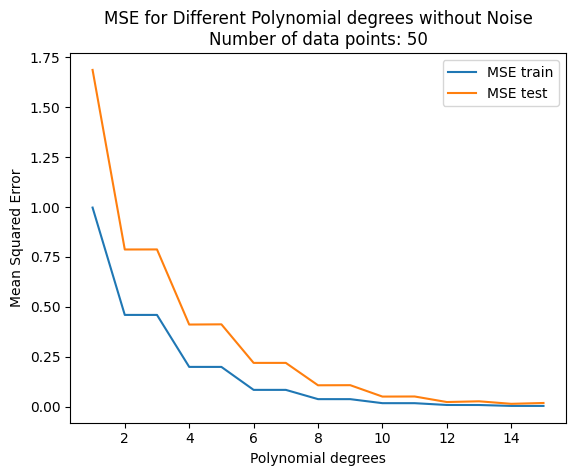

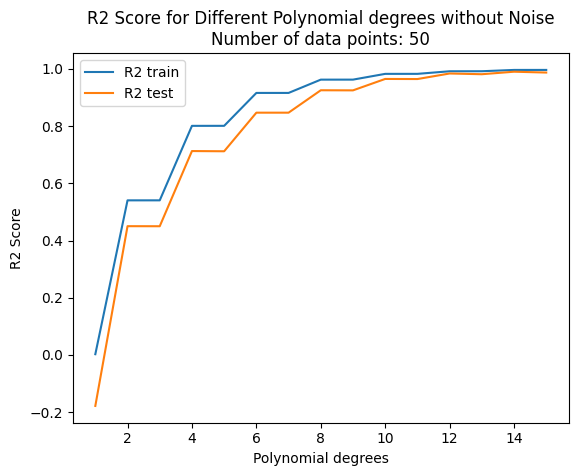

Ridge: Lambda: 0.1, Coef: [-3.05311332e-16 -8.61848332e-02 -3.03482266e+00  1.30165323e-01
  2.70385150e+00 -2.15486313e-02  8.10548700e-01 -2.83191489e-02
 -4.74179655e-01 -7.99626993e-03 -7.21539455e-01  7.71999210e-03
 -3.49548630e-01  8.21555605e-03  3.08486524e-01 -8.49796742e-03]
Lambda: 0.1, MSE_train_ridge: 0.13122539554192023, MSE_test_OLS: 0.3339522031908275
Lambda: 0.1, R2_train_ridge: 0.8687746044580797, R2_test_ridge: 0.766778591369093 

Ridge: Lambda: 0.08286427728546843, Coef: [-3.33066907e-16 -8.69800811e-02 -3.17448487e+00  1.36873149e-01
  3.02778960e+00 -2.72152980e-02  7.70604815e-01 -3.02536429e-02
 -6.46122227e-01 -8.49277393e-03 -8.46140014e-01  7.50994863e-03
 -3.48524023e-01  8.57075251e-03  4.56236423e-01 -6.91557276e-03]
Lambda: 0.08286427728546843, MSE_train_ridge: 0.1240360986319818, MSE_test_OLS: 0.32145166022274396
Lambda: 0.08286427728546843, R2_train_ridge: 0.8759639013680182, R2_test_ridge: 0.7755085659337516 

Ridge: Lambda: 0.06866488450043001, Coef:

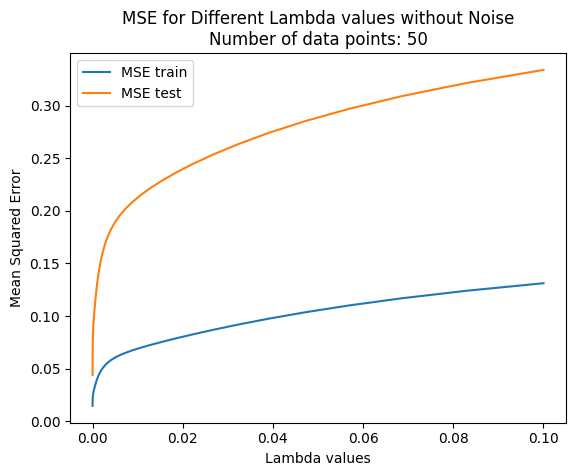

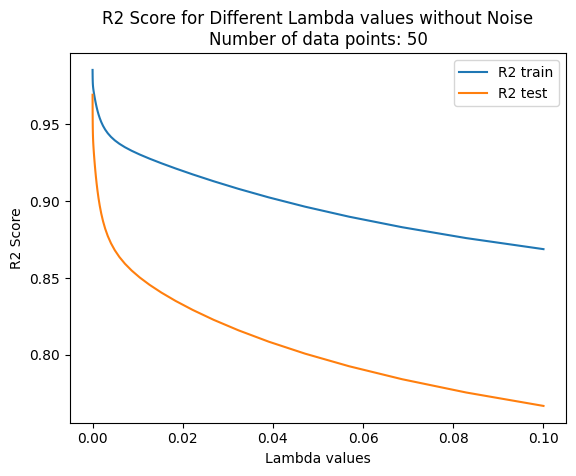

Polynomial degree: 1, MSE_train_OLS: 0.9994767237450057, MSE_test_OLS: 1.9588762651918157
Polynomial degree: 1, R2_train_OLS: 0.0005232762549942649, R2_test_OLS: -0.09069941402919302
Polynomial degree: 1, Sklearn test R2: -0.09069941402919302, Sklearn test MSE: 1.9588762651918157
Polynomial degree: 1, R2 test: Own - sklearn 0.0, MSE test: Own - sklearn 0.0
Polynomial degree: 1, Coef: [0.         0.02287523], intercept: -1.3052397994291281e-17


Polynomial degree: 2, MSE_train_OLS: 0.40534709302565197, MSE_test_OLS: 1.1190269701331657
Polynomial degree: 2, R2_train_OLS: 0.594652906974348, R2_test_OLS: 0.37692743421566144
Polynomial degree: 2, Sklearn test R2: 0.37692743421566155, Sklearn test MSE: 1.1190269701331654
Polynomial degree: 2, R2 test: Own - sklearn -1.1102230246251565e-16, MSE test: Own - sklearn 2.220446049250313e-16
Polynomial degree: 2, Coef: [ 0.         -0.06329368 -0.77559958], intercept: 2.604631191129289e-16


Polynomial degree: 3, MSE_train_OLS: 0.40531942203467874,

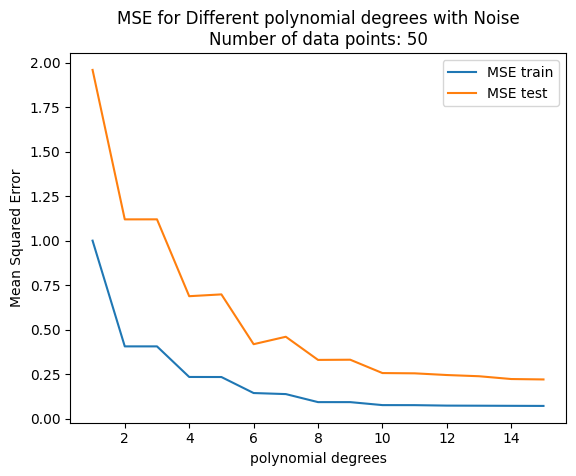

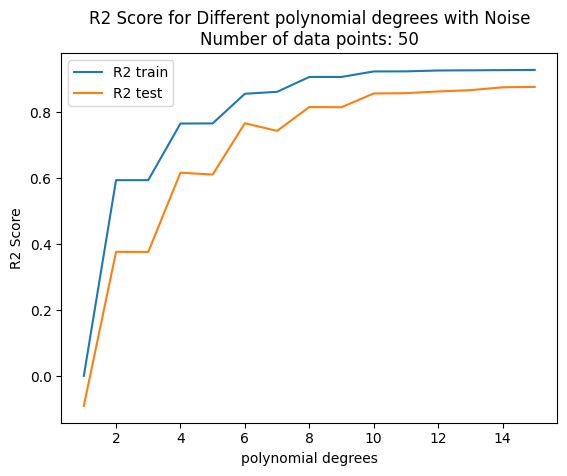

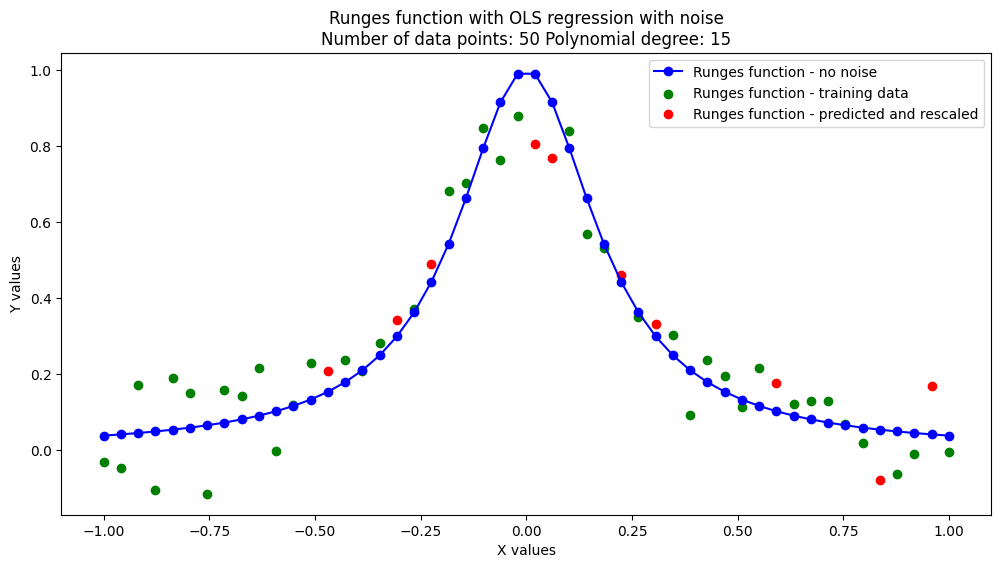

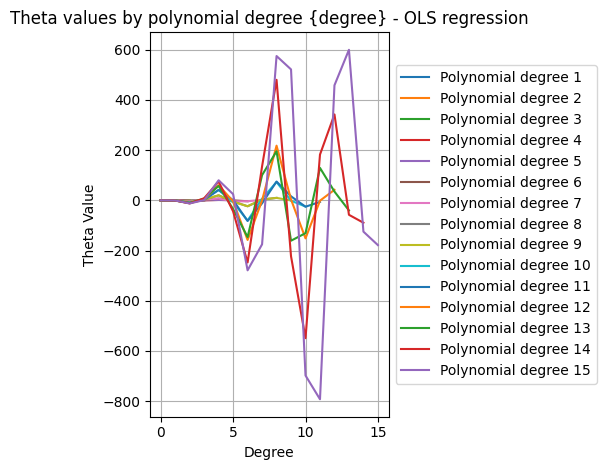

Ridge: Lambda: 0.1, Coef: [-1.24900090e-16 -2.32417101e-01 -2.70936186e+00  5.27480432e-01
  2.39930937e+00 -1.68779329e-01  6.26479531e-01 -3.03883933e-01
 -5.17342749e-01 -1.82965716e-01 -6.79660853e-01 -8.40661640e-03
 -2.80127197e-01  1.32308194e-01  3.64180882e-01  2.11673605e-01]
Lambda: 0.1, MSE_train_ridge: 0.17496638630111044, MSE_test_OLS: 0.6017688518978895
Lambda: 0.1, R2_train_ridge: 0.8250336136988896, R2_test_ridge: 0.6649359912062758 

Ridge: Lambda: 0.08286427728546843, Coef: [-1.80411242e-16 -2.45801325e-01 -2.83564935e+00  5.74485041e-01
  2.69677027e+00 -1.94970992e-01  5.86782404e-01 -3.27968245e-01
 -6.77804238e-01 -1.88317863e-01 -7.93575181e-01 -3.77055854e-04
 -2.77103293e-01  1.42945728e-01  5.01032029e-01  2.14514416e-01]
Lambda: 0.08286427728546843, MSE_train_ridge: 0.16875443509554594, MSE_test_OLS: 0.587518424781773
Lambda: 0.08286427728546843, R2_train_ridge: 0.8312455649044541, R2_test_ridge: 0.6728706079972409 

Ridge: Lambda: 0.06866488450043001, Coef:

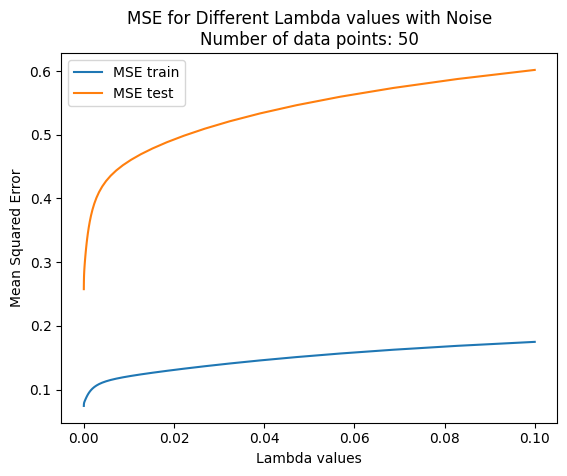

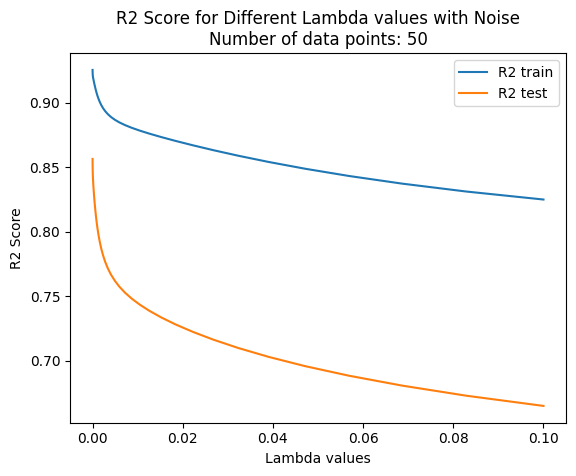

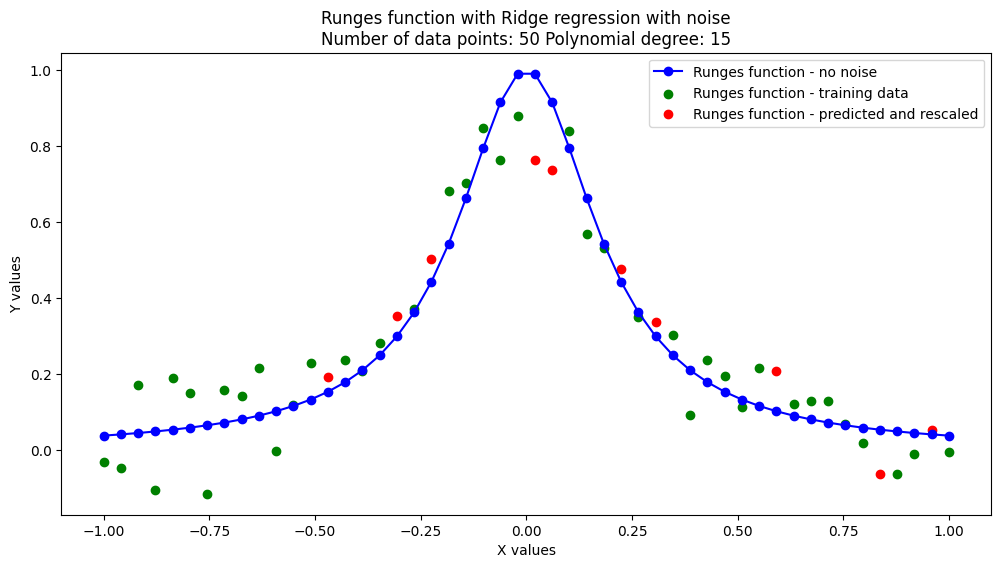

Lasso: Lambda: 1e-05, MSE_train_lasso: 0.148768757795425, MSE_test_lasso: 0.35201771674948507
Lasso: Lambda: 1e-05, R2_train_lasso: 0.851231242204575, R2_test_lsso: 0.7541622214828213
Lasso own implementation best result: Lambda: 1e-05, Learning rate: 0.1, MSE: 0.35201771674948507
Lasso coef: [ 0.00000000e+00 -9.36132353e-02 -2.86692603e+00  1.22180938e-01
  1.97610392e+00  3.52572978e-05  1.06651042e+00 -1.90877793e-02
  8.07397651e-02 -7.11939664e-03 -3.69624043e-01  4.85958140e-03
 -4.20250928e-01  3.17340378e-03 -2.43245374e-01 -1.29123331e-02], intercept: -5.666112129692762e-17
Rescaled sklearn coef and interceot with own code
 Rescaled coef: [-4.12602274e-02 -2.49945785e+00  7.93407222e-02  1.82469951e+00
  2.76932344e-05  1.05216726e+00 -1.68222590e-02  8.38971071e-02
 -6.77442193e-03 -3.99467962e-01  4.88034258e-03 -4.67860570e-01
  3.31450002e-03 -2.76957851e-01 -1.38861306e-02], rescaled intercept 0.6777614968498898


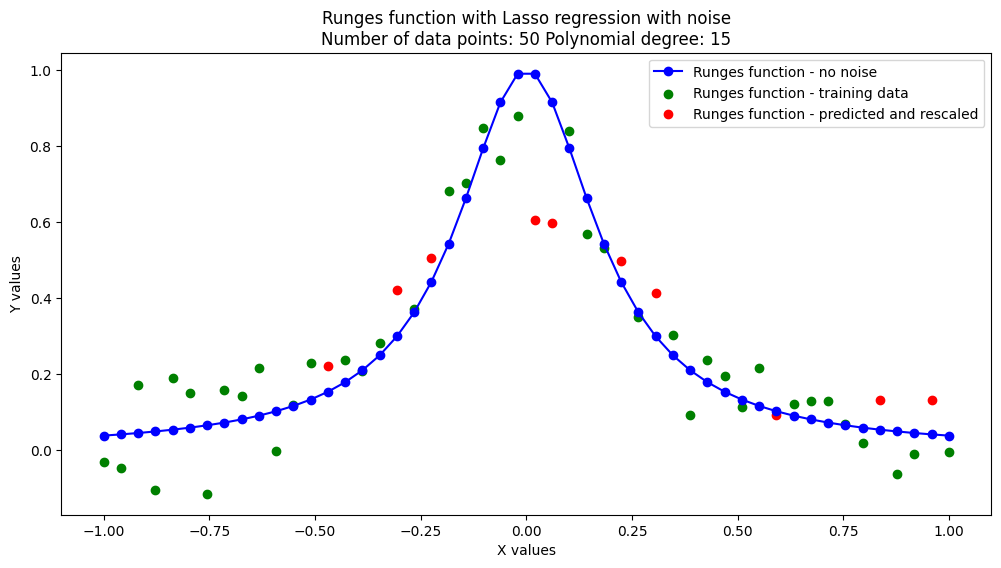

<Figure size 600x400 with 0 Axes>

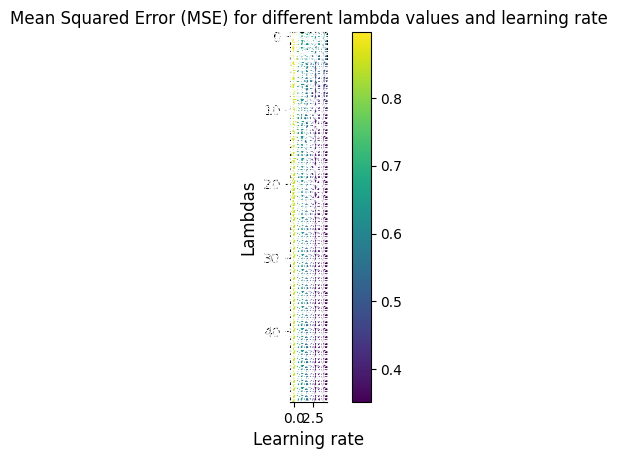

<Figure size 600x400 with 0 Axes>

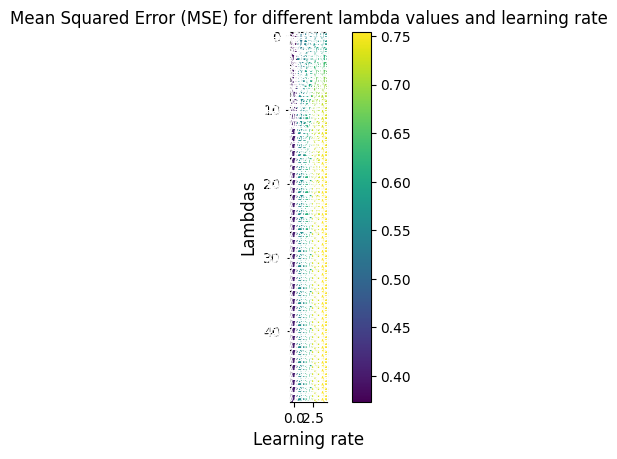

lasso - not scaled
Sklearn coef: [ 0.         -0.00884025 -4.27480309 -0.12385803  7.91757443  0.47400694
 -3.28429635 -0.27965368 -2.10979007 -0.19555326 -0.33049075 -0.
  0.38088375  0.          0.98688537  0.13036482], Sklearn intercept: 0.7548400936518664
lasso - scaled
Sklearn coef: [ 0.00000000e+00 -1.30103770e-02 -4.95652934e+00 -2.79833714e-01
  8.75779929e+00  8.66892802e-01 -3.45860974e+00 -5.22855791e-01
 -2.08692942e+00 -2.53324244e-01 -3.64339230e-01  4.93216015e-04
  4.93296809e-01  8.28998897e-02  8.29749939e-01  1.10315981e-01], Sklearn intercept: -1.3878934144088798e-15


c:\Users\brumor\AppData\Local\miniconda3\envs\4155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.963e-02, tolerance: 2.868e-06
  model = cd_fast.enet_coordinate_descent(
c:\Users\brumor\AppData\Local\miniconda3\envs\4155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.313e+00, tolerance: 4.000e-05
  model = cd_fast.enet_coordinate_descent(


In [8]:
# Runge's function analysis
##################################################


# OLS as function of polynomial degree
# No noise
# creating design matrix with polynomial features: p
X = polynomial_features(x, p,intercept=use_intercept) # intercept=True gives intercept column = 0 in standard scaler if intercept is True, and hence division by 0. 

# split x for plotting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state_int)
# test and train dataset, and scaling of X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_int)
X_train_scaled, X_test_scaled, X_train_mean, X_train_std = scale_features_by_intercept_use(X_train, X_test, use_intercept)
# scaling of y_train and y_test
y_train_scaled, y_test_scaled, y_train_mean, y_train_std = standard_scaler(y_train, y_test)




# Calcualte OLS with sklearn as baseline values of intercept and theta
# Compare other regression results to this
ols_model_not_scaled = LinearRegression(fit_intercept=use_intercept)
ols_model_scaled = LinearRegression(fit_intercept=use_intercept)
ols_sklearn_not_scaled = ols_model_not_scaled.fit(X_train, y_train)
ols_sklearn_scaled = ols_model_scaled.fit(X_train_scaled, y_train_scaled)
print("Baseline with OLS for comparison of other regressions")
print(f"sklearn OLS not scaled. Coef: {ols_sklearn_not_scaled.coef_}, intercept: {ols_sklearn_not_scaled.intercept_} ")
print(f"sklearn OLS scaled. Coef: {ols_sklearn_scaled.coef_}, intercept: {ols_sklearn_scaled.intercept_}")
rescaled_coef, rescaled_intercept = rescale_theta_intercept(ols_sklearn_scaled.coef_[1:], ols_sklearn_scaled.intercept_, y_train_std, y_train_mean, X_train_std, X_train_mean, verbose=verbose_bool)
print('\n\n\n\n')



################ Regression without noise
# scaled data for features as input 
polynomial_degree, mse_train, mse_test, r2_train, r2_test, thetas_ols_noise = explore_polynomial_degree(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, p, use_intercept=use_intercept, verbose=verbose_bool)
# rescaled coef and intercept as qc
rescaled_coef_ols, rescaled_intercept_ols = rescale_theta_intercept(thetas_ols_noise[-1][1:], thetas_ols_noise[-1][0], y_train_std, y_train_mean, X_train_std, X_train_mean, verbose=verbose_bool)
y_predicted_scaled_ols = predict_y(X_test_scaled[:, 1:], rescaled_coef_ols)
y_predicted_rescaled_ols = rescale_y(y_predicted_scaled_ols, y_train_std, y_train_mean)

if create_plots:
    plot_mse(n_datapoints, polynomial_degree,"Polynomial degrees", mse_train, mse_test, noise=False)
    plot_r2(n_datapoints, polynomial_degree,"Polynomial degrees", r2_train, r2_test, noise=False)


# Explore lambdas with Ridge regression - no noise
lambdas, mse_train_ridge, mse_test_ridge, r2_train_ridge, r2_test_ridge, theta_ridge = explore_lambda(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, lambdas_start, verbose=verbose_bool)
# rescaled coef and intercept as qc
rescaled_coef_ridge, rescaled_intercept_ridge = rescale_theta_intercept(theta_ridge[1:], theta_ridge[0], y_train_std, y_train_mean, X_train_std, X_train_mean, verbose=verbose_bool)
y_predicted_scaled_ridge = predict_y(X_test_scaled[:, 1:], rescaled_coef_ridge)
y_predicted_rescaled_risge = rescale_y(y_predicted_scaled_ridge, y_train_std, y_train_mean)

if create_plots: #MSE and R2 with no noise
    plot_mse(n_datapoints, lambdas,"Lambda values", mse_train_ridge, mse_test_ridge, noise=False)
    plot_r2(n_datapoints, lambdas,"Lambda values", r2_train_ridge, r2_test_ridge, noise=False)


################# Regression with noise
# creating design matrix with polynomial features: p
X_noise = polynomial_features(x_noise, p,intercept=use_intercept) # intercept=True gives intercept column = 0 in standard scaler if intercept is True, and hence division by 0. Leaving intercept out since Ridge regression handles this

# test and train dataset, and scaling of X_train and X_test
x_train_noise, x_test_noise, y_train_noise, y_test_noise = train_test_split(x_noise, y_noise, test_size=0.2, random_state=random_state_int)
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise, y_noise, test_size=0.2, random_state = random_state_int)
X_train_scaled_noise, X_test_scaled_noise, X_mean, X_std = scale_features_by_intercept_use(X_train_noise, X_test_noise, use_intercept)
# scaling of y_train and y_test
y_train_scaled_noise, y_test_scaled_noise, y_train_mean_noise, y_train_std_noise = standard_scaler(y_train_noise, y_test_noise)

### OLS
# scaled data for features as input
polynomial_degree, mse_train, mse_test, r2_train, r2_test, thetas_ols_noise = explore_polynomial_degree(X_train_scaled_noise, X_test_scaled_noise, y_train_scaled_noise, y_test_scaled_noise, p, use_intercept=use_intercept, verbose=verbose_bool)
# rescaled coef and intercept as qc, calculated rescaled y_predict
rescaled_coef_ols_noise, rescaled_intercept_ols_noise = rescale_theta_intercept(thetas_ols_noise[-1][1:], thetas_ols_noise[-1][0], y_train_std, y_train_mean, X_train_std, X_train_mean, verbose=verbose_bool)
y_predicted_scaled_ols_noise = predict_y(X_test_scaled_noise[:, 1:], rescaled_coef_ols_noise)
y_predicted_rescaled_ols_noise = rescale_y(y_predicted_scaled_ols_noise, y_train_std, y_train_mean)
if create_plots: #MSE, R2 and function with noise
    plot_mse(n_datapoints, polynomial_degree, "polynomial degrees", mse_train, mse_test, noise=True)
    plot_r2(n_datapoints, polynomial_degree, "polynomial degrees",r2_train, r2_test, noise=True)
    plot_xy_xynoise_ypredicted(x, y, x_train_noise, y_train_noise, y_predicted_rescaled_ols_noise, x_test, n_datapoints, "OLS", p, noise=True)

# Plot theta values as function if polynomial degree
if create_plots: plot_theta_by_polynomials(thetas_ols_noise, p)

# Explore lambdas with Ridge regression - noise
lambdas, mse_train_ridge, mse_test_ridge, r2_train_ridge, r2_test_ridge, thetas_ridge_noise = explore_lambda(X_train_scaled_noise, X_test_scaled_noise, y_train_scaled_noise, y_test_scaled_noise, lambdas_start, verbose=verbose_bool)
# rescaled coef and intercept as qc
rescaled_coef_ridge_noise, rescaled_intercept_ridge_noise = rescale_theta_intercept(thetas_ridge_noise[1:], thetas_ridge_noise[0], y_train_std, y_train_mean, X_train_std, X_train_mean, verbose=verbose_bool)
y_predicted_scaled_ridge_noise = predict_y(X_test_scaled_noise[:, 1:], rescaled_coef_ridge_noise) 
y_predicted_rescaled_ridge_noise = rescale_y(y_predicted_scaled_ridge_noise, y_train_std, y_train_mean)

if create_plots:
    plot_mse(n_datapoints, lambdas,"Lambda values", mse_train_ridge, mse_test_ridge, noise=True)
    plot_r2(n_datapoints, lambdas,"Lambda values", r2_train_ridge, r2_test_ridge, noise=True)
    plot_xy_xynoise_ypredicted(x, y, x_train_noise, y_train_noise, y_predicted_rescaled_ridge_noise, x_test, n_datapoints, "Ridge", p, noise=True)



##################################################
# Explore Lasso regression as function of lambdas and learning rate ----- Only used withot noise
lasso_grid, lasso_mse_train, lasso_mse_test, lasso_r2_train, lasso_r2_test, lasso_mse_values, lasso_r2_values = lasso_grid_search(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, lambdas_start, etas, tolerance, max_iterations, use_intercept, verbose=verbose_bool)
# rescaled coef and intercept as qc
rescaled_coef_lasso_noise, rescaled_intercept_lasso_noise = rescale_theta_intercept(lasso_grid['coef'][1:], lasso_grid['intercept'], y_train_std, y_train_mean, X_train_std, X_train_mean, verbose=verbose_bool)
y_predicted_scaled_lasso_noise = predict_y(X_test_scaled_noise[:, 1:], rescaled_coef_lasso_noise)
y_predicted_rescaled_lasso_noise = rescale_y(y_predicted_scaled_lasso_noise, y_train_std, y_train_mean)
if create_plots:
    plot_xy_xynoise_ypredicted(x, y, x_train_noise, y_train_noise, y_predicted_rescaled_lasso_noise, x_test, n_datapoints, "Lasso", p, noise=True)
plot_heatmap_lasso(lasso_mse_values, lambda_n, etas)

plot_heatmap_lasso(lasso_r2_values, lambda_n, etas)

# compare with lasso sklearn - use best alpha value from own implementation and calculation of lasso
if verbose_bool: print('lasso - not scaled')
sklearn_lasso_regression(X_train, y_train, lasso_grid['lambda'], use_intercept, max_iterations, tolerance, verbose=verbose_bool)
if verbose_bool: print('lasso - scaled')
sklearn_lasso_regression(X_train_scaled, y_train_scaled, lasso_grid['lambda'], use_intercept, max_iterations, tolerance, verbose=verbose_bool)




# About scaling - information for report

See "machine learning with Python and Scikit-learn - page 119-122" and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section.
From scikit documentation handling of outliers are important when scaling. Standard scaler is not robust to outliers, men our dataset is generated with some noise but no outliers. Standard scaler is hence ok to use, and mean and variance is mentioned. Write arguement for using standard scaler and not normaliazation.

From lecture notes: 

The StandardScaler function in Scikit-Learn ensures that for each feature/predictor we study the mean value is zero and the variance is one (every column in the design/feature matrix). This scaling has the drawback that it does not ensure that we have a particular maximum or minimum in our data set.

The Normalizer scales each data point such that the feature vector has a euclidean length of one. In other words, it projects a data point on the circle (or sphere in the case of higher dimensions) with a radius of 1. 
This means every data point is scaled by a different number (by the inverse of it’s length). This normalization is often used when only the direction (or angle) of the data matters, not the length of the feature vector.

The RobustScaler works similarly to the StandardScaler in that it ensures statistical properties for each feature that guarantee that they are on the same scale. 
However, the RobustScaler uses the median and quartiles, instead of mean and variance. This makes the RobustScaler ignore data points that are very different from the rest (like measurement errors). 
These odd data points are also called outliers, and might often lead to trouble for other scaling techniques.